# Introduction

How much does what is included in the annotation set matter?

In [1]:
import seaborn
import scipy
import anndata
import pandas
import scanpy
import numpy
from pathlib import Path
from matplotlib import pyplot, cm
import sys
import pysam
from collections import Counter
from IPython import display

import upsetplot

In [2]:
pandas.options.display.max_rows = 300

In [3]:
pwd

'/woldlab/loxcyc/home/diane/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/adrenal'

In [4]:
project_root = Path("~diane/proj/encode-202006-jamboree-detrout-rna-sc-pipeline").expanduser().absolute()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
from common import compute_spearman_anndata

In [5]:
v29_genome_dir = Path("~/proj/genome/").expanduser()
v29_store = pandas.HDFStore(v29_genome_dir / "GRCh38-V29-male" / "GRCh38-V29-male.h5")
v29_gtf = v29_store.select('/gtf', where='type == gene', columns=['gene_id', 'gene_name', 'gene_type'])
v29_store.close()

v29_gene_base_to_id = {}
v29_gene_id_to_name = {}
v29_gene_id_to_type = {}
for i, row in v29_gtf.iterrows():
    v29_gene_base_to_id[row.gene_id.split('.')[0]] = row.gene_id
    v29_gene_id_to_name[row.gene_id] = row.gene_name
    v29_gene_id_to_type[row.gene_id] = row.gene_type

def calculate_v29_gene_base(gene_id):
    gene_base = gene_id.split('.')[0]
    if gene_id.endswith("_PAR_Y"):
        gene_base += "_PAR_Y"
    return gene_base
v29_gtf['gene_base'] = v29_gtf['gene_id'].apply(calculate_v29_gene_base)

In [6]:
v32m_genome_dir = Path("~/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/genome/").expanduser()
v32m_store = pandas.HDFStore(v32m_genome_dir / "GRCh38-arc2.0-2.7.8a" / "GRCh38-arc2.0-2.7.8a.h5")
v32m_gtf = v32m_store.select('/gtf', where='type == gene', columns=['gene_id', 'gene_name', 'gene_type'])
v32m_store.close()

v32m_gtf.columns = ['gene_base', 'gene_name', 'gene_type']
v32m_gtf['gene_id'] = v32m_gtf['gene_base'].apply(lambda x: v29_gene_base_to_id.get(x, x))

v32m_gene_id_to_name = {}
v32m_gene_id_to_type = {}
for i, row in v32m_gtf.iterrows():
    v32m_gene_id_to_name[row.gene_id] = row.gene_name
    v32m_gene_id_to_type[row.gene_id] = row.gene_type

In [7]:
def scanpy_load_solo278a_mtx(analysis_dir, quantification="Gene", mode="filtered", multiread="Unique"):
    assert mode in ["filtered", "raw"], "STAR Solo only produces raw or filtered files"
    assert quantification in ["Gene", "GeneFull", "GeneFull_Ex50pAS", "SJ"]
    MULTIREAD_MATRIX = {
    "Unique": "matrix.mtx",
    "Rescue": "UniqueAndMult-Rescue.mtx",
    "EM": "UniqueAndMult-EM.mtx",
    }
    assert multiread in MULTIREAD_MATRIX

    analysis_dir = Path(analysis_dir)
    
    solo_dir = analysis_dir / "Solo.out" / quantification 
    solo = scanpy.read_mtx(solo_dir / "raw" / MULTIREAD_MATRIX[multiread]).T
    solo_vars = pandas.read_csv(
        solo_dir / "raw" / "features.tsv", header=None, sep="\t"
    ).values.T
    solo_obs = pandas.read_csv(
        solo_dir / "raw" / "barcodes.tsv", header=None, sep="\t"
    ).values.T
    solo.obs_names = solo_obs[0]
    solo.var_names = solo_vars[0]
    
    if mode == "filtered":
        solo_obs = pandas.read_csv(
            solo_dir / mode / "barcodes.tsv", header=None, sep="\t"
        ).values.T[0]
        solo = solo[solo_obs,:]
        

    solo.obs["counts"] = solo.X.sum(axis=1)
    solo.obs["ngenes"] = numpy.array((solo.X > 0).sum(axis=1))

    return solo



I tried to do an analysis using the the different modes of soloMultiMappers but they seemed too similar.
Then I computed the md5sum of the matrix files... and yeah the argument didn't seem to do anything.

<table>
<tr><td>ffb6d23ee397674a310d93039e4111a7</td><td>fullsolo_2.7.9a_2021-06-25/Solo.out/GeneFull/filtered/matrix.mtx</td></tr>
<tr><td>ffb6d23ee397674a310d93039e4111a7</td><td>fullsolo_em_2.7.9a_2021-06-25/Solo.out/GeneFull/filtered/matrix.mtx</td></tr>
<tr><td>ffb6d23ee397674a310d93039e4111a7</td><td>fullsolo_rescue_2.7.9a_2021-06-25/Solo.out/GeneFull/filtered/matrix.mtx</td></tr>
<tr><td>00dd2450e656ceaffe533c4558e16227</td><td>minimalsolo_2.7.9a_2021-06-25/Solo.out/GeneFull/filtered/matrix.mtx</td></tr>
<tr><td>00dd2450e656ceaffe533c4558e16227</td><td>minimalsolo_em_2.7.9a_2021-06-25/Solo.out/GeneFull/filtered/matrix.mtx</td></tr>
<tr><td>00dd2450e656ceaffe533c4558e16227</td><td>minimalsolo_rescue_2.7.9a_2021-06-25/Solo.out/GeneFull/filtered/matrix.mtx</td></tr>
</table>

I also learned that there's some gene base ids that have two version varients. (One example)
<table>
<tr><td>gene_id 	</td><td>gene_name 	</td><td>gene_type</td></tr>
<tr><td>ENSG00000169084.13 	</td><td>DHRSX 	</td><td>protein_coding</td></tr>
    <tr><td>ENSG00000169084.13_PAR_Y 	</td><td>DHRSX 	</td><td>protein_coding</td></tr>
</table>

# Load Datasets

In [8]:
run_dir = "tenxsolo_multi_2.7.9a_2021-06-25"
algorithm_roots = {
    "26m full uniq 362YDM": (Path("ENCSR362YDM_26m_nuc") / run_dir, "GeneFull", "filtered", "Unique"),
    "16f full uniq 724KET": (Path("ENCSR724KET_16f_nuc") / run_dir, "GeneFull", "filtered", "Unique"),
    "59f full uniq 726IPC": (Path("ENCSR726IPC_59f_nuc") / run_dir, "GeneFull", "filtered", "Unique"),    
}

algorithm_suffix = {
    "26m full uniq 362YDM": "26m",
    "16f full uniq 724KET": "16f",
    "59f full uniq 726IPC": "59f",
}
#Path("ENCSR362YDM_26m_nuc/fullsolo_multi_2.7.9a_2021-06-25/GeneFull_EM.tar.gz
#Path("ENCSR724KET_16f_nuc/fullsolo_multi_2.7.9a_2021-06-25/GeneFull_EM.tar.gz
#Path("ENCSR726IPC_59f_nuc/fullsolo_multi_2.7.9a_2021-06-25/GeneFull_EM.tar.gz
    

In [9]:
algorithm_filtered = {}
for algorithm in algorithm_roots:
    root, quantification, filtering, multiread = algorithm_roots[algorithm]
    print("loading {}".format(algorithm))
    algorithm_filtered[algorithm] = scanpy_load_solo278a_mtx(root, quantification, filtering, multiread)
    print(algorithm, algorithm_filtered[algorithm].shape, algorithm_filtered[algorithm].X.sum())

loading 26m full uniq 362YDM


Trying to set attribute `.obs` of view, copying.


26m full uniq 362YDM (11964, 36601) 61086730.0
loading 16f full uniq 724KET


Trying to set attribute `.obs` of view, copying.


16f full uniq 724KET (15812, 36601) 84269840.0
loading 59f full uniq 726IPC


Trying to set attribute `.obs` of view, copying.


59f full uniq 726IPC (12732, 36601) 57443816.0


# Add (faked) version to 10x annotation

The 10x provided annotation GTF file, based on GENCODE V32, has the gene version number removed, to make later comparisons easier I added the gene version number from my V29 GTF on to the V32 gene base ids.

(Gene base = ENSG00000243485)

(Gene id with version = ENSG00000243485.5)

In [10]:
for algorithm in algorithm_filtered:
    if algorithm.startswith("tenx"):
        algorithm_filtered[algorithm].var_names = v32m_gtf.set_index('gene_base').reindex(algorithm_filtered[algorithm].var_names.to_list())['gene_id']

# Remove version from ENCODE annotations

In [11]:
#algorithm_filtered['encode minimal solo uniq'].var_names

In [12]:
#for algorithm in algorithm_filtered:
#    if algorithm != 'tenx solo uniq':
#        algorithm_filtered[algorithm].var_names = [x.split('.')[0] for x in algorithm_filtered[algorithm].var_names]


In [13]:
#algorithm_filtered['encode minimal solo uniq'].var_names

In [14]:
algorithm_filtered

{'26m full uniq 362YDM': AnnData object with n_obs × n_vars = 11964 × 36601
     obs: 'counts', 'ngenes',
 '16f full uniq 724KET': AnnData object with n_obs × n_vars = 15812 × 36601
     obs: 'counts', 'ngenes',
 '59f full uniq 726IPC': AnnData object with n_obs × n_vars = 12732 × 36601
     obs: 'counts', 'ngenes'}

# Cell barcodes in common

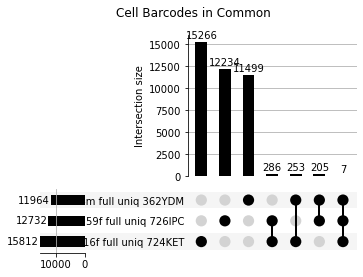

In [15]:
algorithm_cell_barcodes = {}
for algorithm in algorithm_filtered:
    algorithm_cell_barcodes[algorithm] = algorithm_filtered[algorithm].obs_names

common_cell_barcode_set = upsetplot.from_contents(algorithm_cell_barcodes)
f = pyplot.figure()
f.suptitle("Cell Barcodes in Common")
_ = upsetplot.plot(common_cell_barcode_set, fig=f, show_counts=True)


Not much overlap in cell barcodes is there

# localize barcode name to dataset

In [16]:
for algorithm in algorithm_filtered:
    adata = algorithm_filtered[algorithm]
    adata.obs_names = ["{}_{}".format(x, algorithm_suffix[algorithm]) for x in algorithm_filtered[algorithm].obs_names]

# Lets try the scanpy tutorial

26m full uniq 362YDM first phase QC


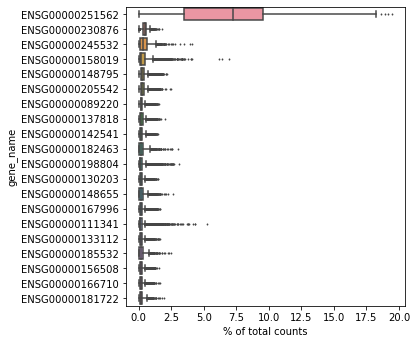

/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored

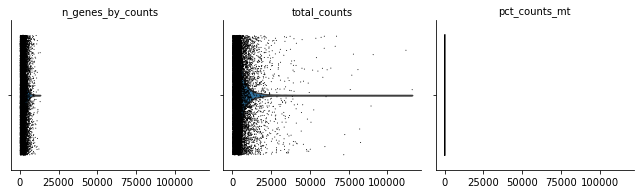

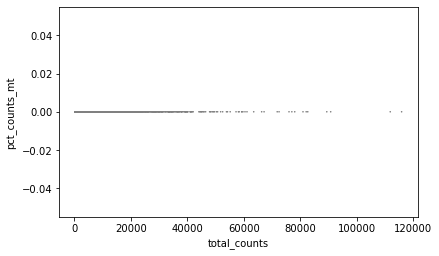

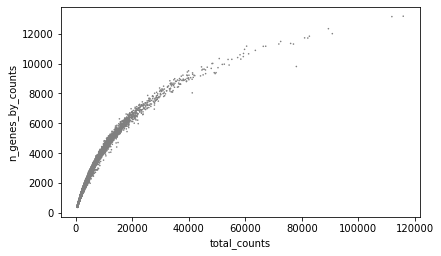

16f full uniq 724KET first phase QC


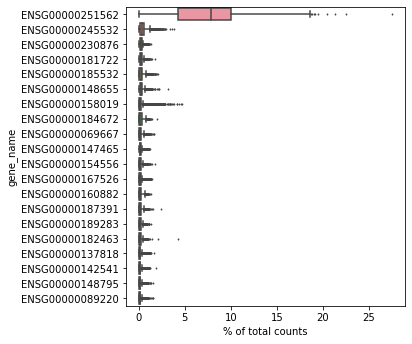

/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored

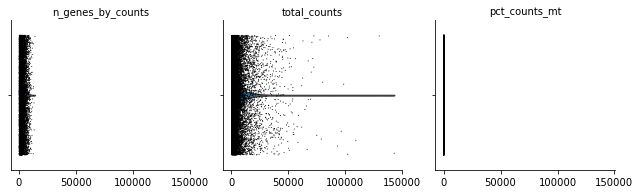

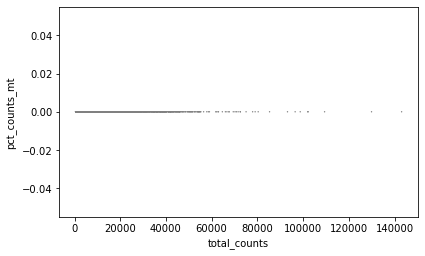

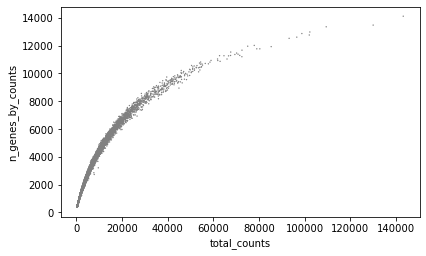

59f full uniq 726IPC first phase QC


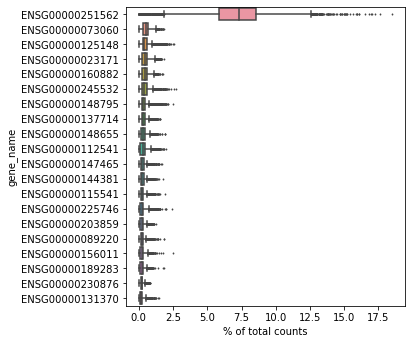

/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored

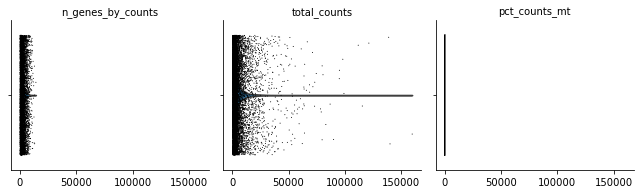

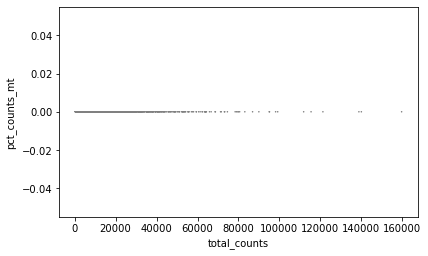

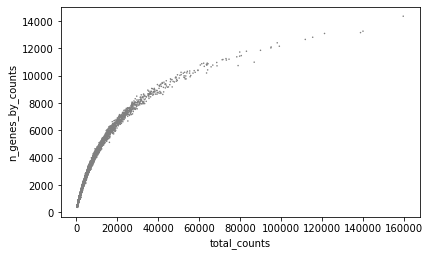

In [17]:
for algorithm in algorithm_filtered:
    print("{algorithm} first phase QC".format(algorithm=algorithm))    
    if algorithm.startswith("tenx"):
        algorithm_filtered[algorithm].var['gene_name'] = [v32m_gene_id_to_name.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
        algorithm_filtered[algorithm].var['gene_type'] = [v32m_gene_id_to_type.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
    else:
        algorithm_filtered[algorithm].var['gene_name'] = [v29_gene_id_to_name.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
        algorithm_filtered[algorithm].var['gene_type'] = [v29_gene_id_to_type.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
        
    scanpy.pl.highest_expr_genes(algorithm_filtered[algorithm], n_top=20, gene_symbols='gene_name')
    scanpy.pp.filter_cells(algorithm_filtered[algorithm], min_genes=200)
    scanpy.pp.filter_genes(algorithm_filtered[algorithm], min_cells=3)
    algorithm_filtered[algorithm].var['mt'] = algorithm_filtered[algorithm].var['gene_name'].str.startswith("MT-")
    scanpy.pp.calculate_qc_metrics(algorithm_filtered[algorithm], qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    scanpy.pl.violin(
        algorithm_filtered[algorithm],
        ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
        jitter=0.4, multi_panel=True)
    scanpy.pl.scatter(algorithm_filtered[algorithm], x='total_counts', y='pct_counts_mt')
    scanpy.pl.scatter(algorithm_filtered[algorithm], x='total_counts', y='n_genes_by_counts')        

26m full uniq 362YDM clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


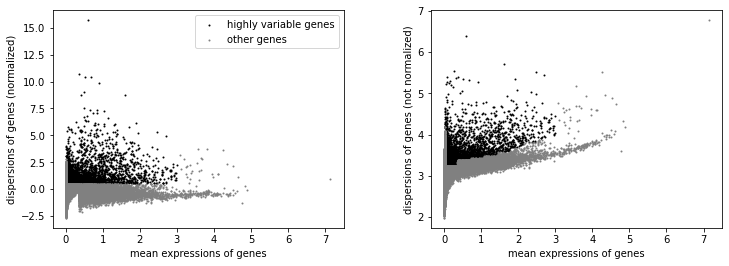

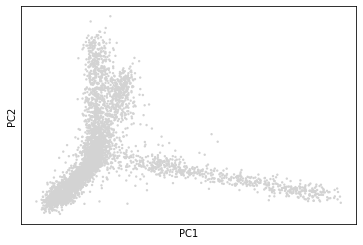

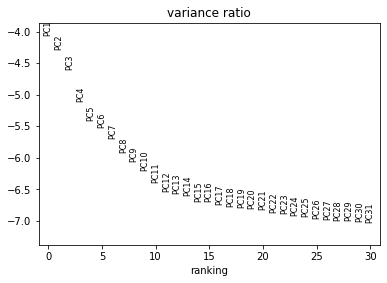

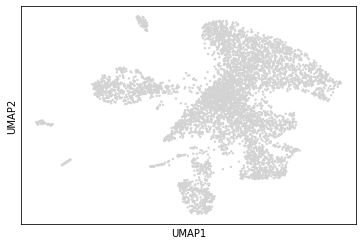

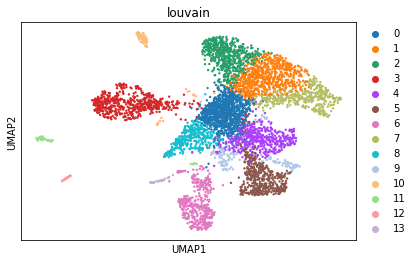

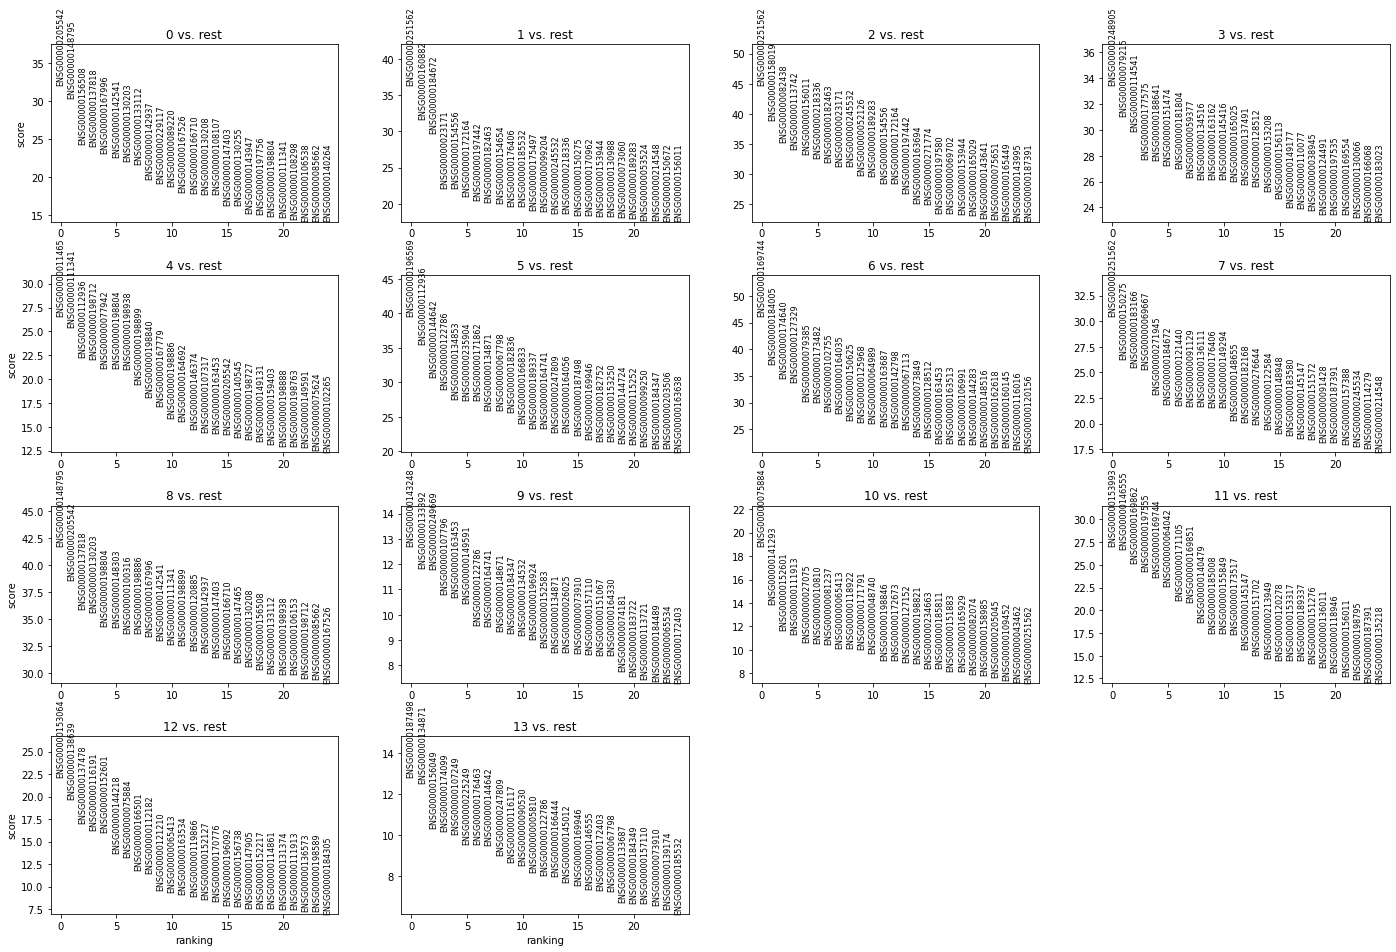

top gene names
                 0                1                2                3  \
0  ENSG00000205542  ENSG00000251562  ENSG00000251562  ENSG00000248905   
1  ENSG00000148795  ENSG00000160882  ENSG00000158019  ENSG00000079215   
2  ENSG00000156508  ENSG00000184672  ENSG00000082438  ENSG00000114541   
3  ENSG00000137818  ENSG00000023171  ENSG00000113742  ENSG00000177575   
4  ENSG00000167996  ENSG00000154556  ENSG00000156011  ENSG00000188641   

                 4                5                6                7  \
0  ENSG00000011465  ENSG00000196569  ENSG00000169744  ENSG00000251562   
1  ENSG00000111341  ENSG00000112936  ENSG00000184005  ENSG00000150275   
2  ENSG00000112936  ENSG00000144642  ENSG00000174640  ENSG00000183166   
3  ENSG00000198712  ENSG00000122786  ENSG00000127329  ENSG00000069667   
4  ENSG00000077942  ENSG00000134853  ENSG00000079385  ENSG00000271945   

                 8                9               10               11  \
0  ENSG00000148795  ENSG0000014324

/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


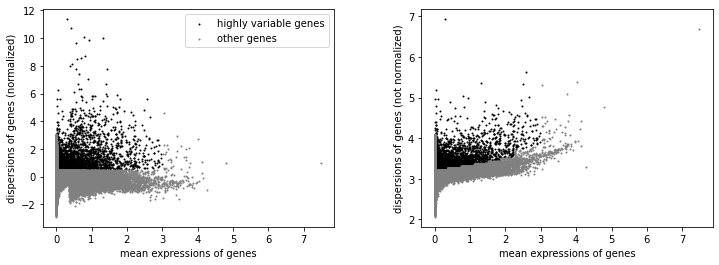

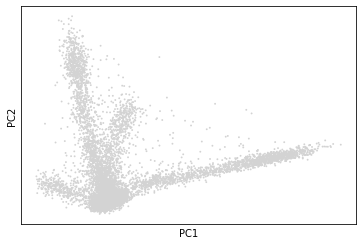

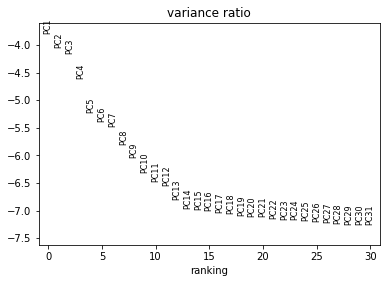

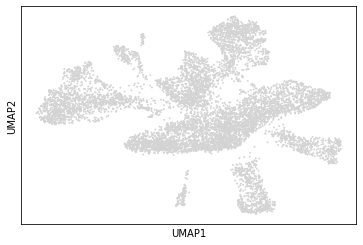

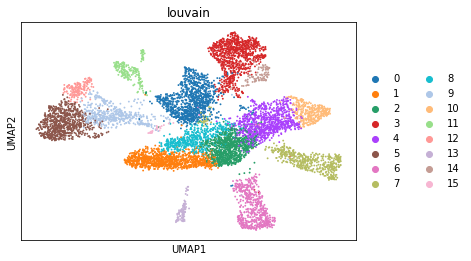

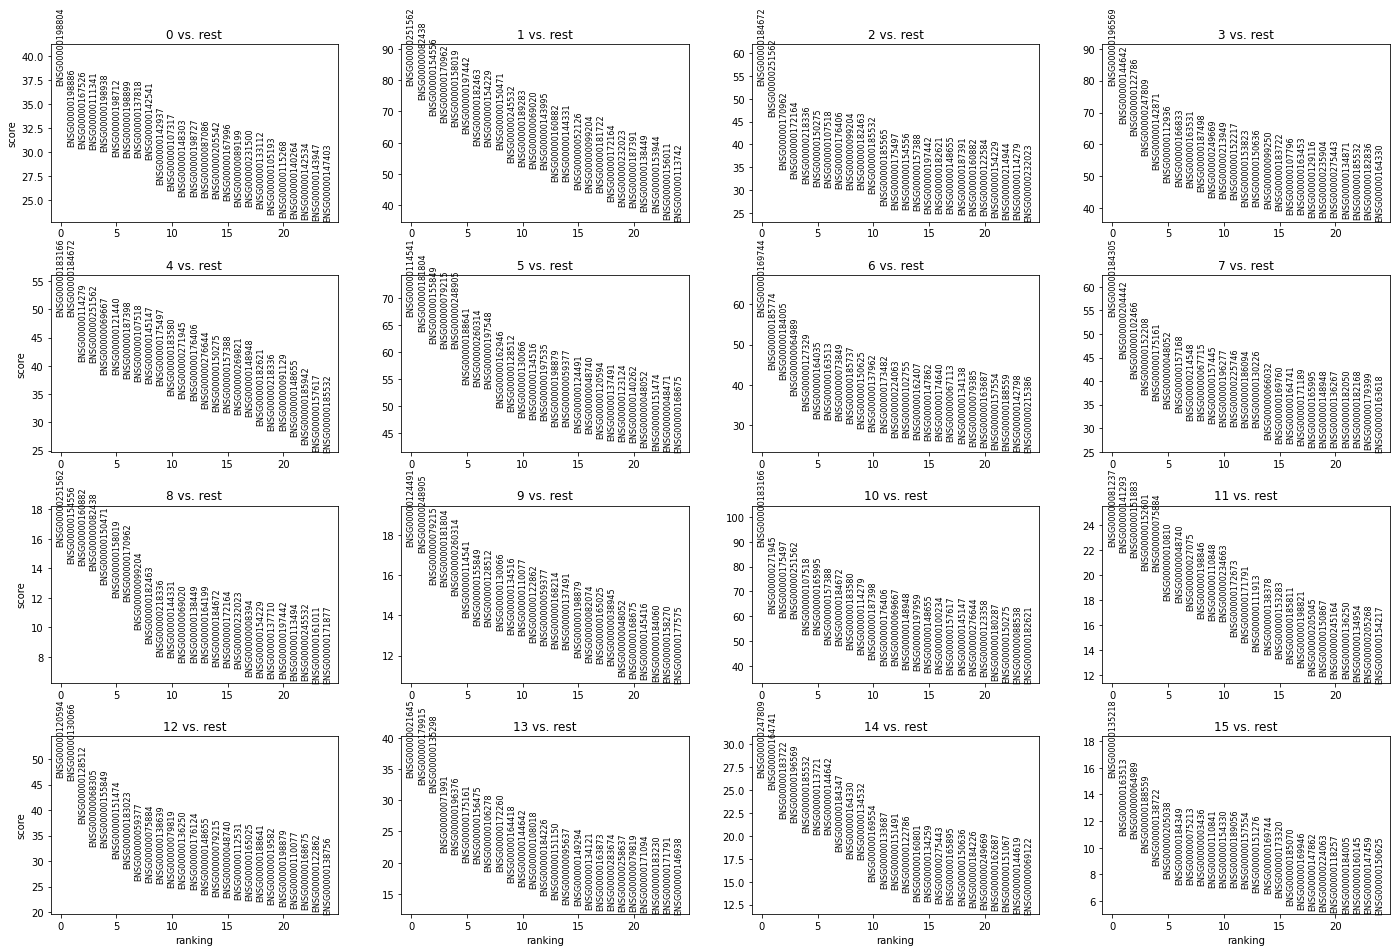

top gene names
                 0                1                2                3  \
0  ENSG00000198804  ENSG00000251562  ENSG00000184672  ENSG00000196569   
1  ENSG00000198886  ENSG00000082438  ENSG00000251562  ENSG00000144642   
2  ENSG00000167526  ENSG00000154556  ENSG00000170962  ENSG00000122786   
3  ENSG00000111341  ENSG00000170962  ENSG00000172164  ENSG00000247809   
4  ENSG00000198938  ENSG00000158019  ENSG00000218336  ENSG00000142871   

                 4                5                6                7  \
0  ENSG00000183166  ENSG00000114541  ENSG00000169744  ENSG00000184305   
1  ENSG00000184672  ENSG00000181804  ENSG00000185774  ENSG00000204442   
2  ENSG00000114279  ENSG00000155849  ENSG00000184005  ENSG00000102466   
3  ENSG00000251562  ENSG00000079215  ENSG00000064989  ENSG00000152208   
4  ENSG00000069667  ENSG00000248905  ENSG00000127329  ENSG00000175161   

                 8                9               10               11  \
0  ENSG00000251562  ENSG0000012449

/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


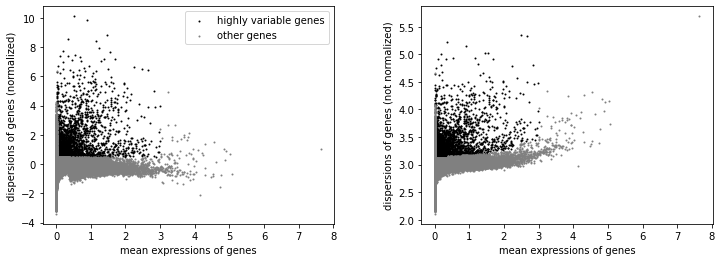

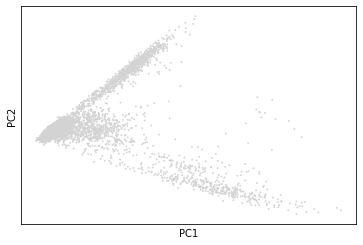

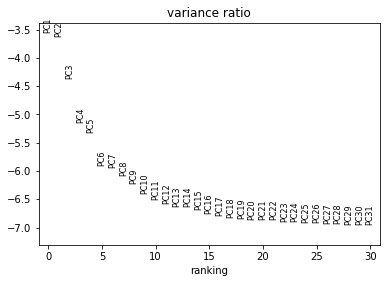

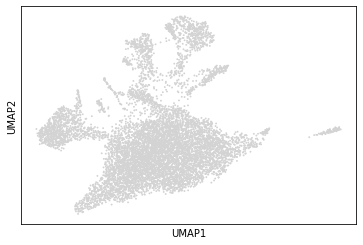

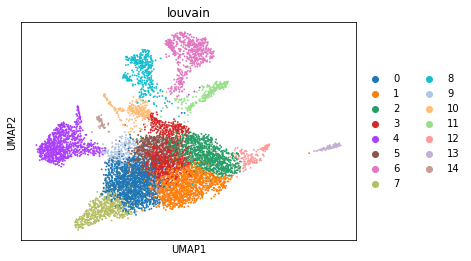

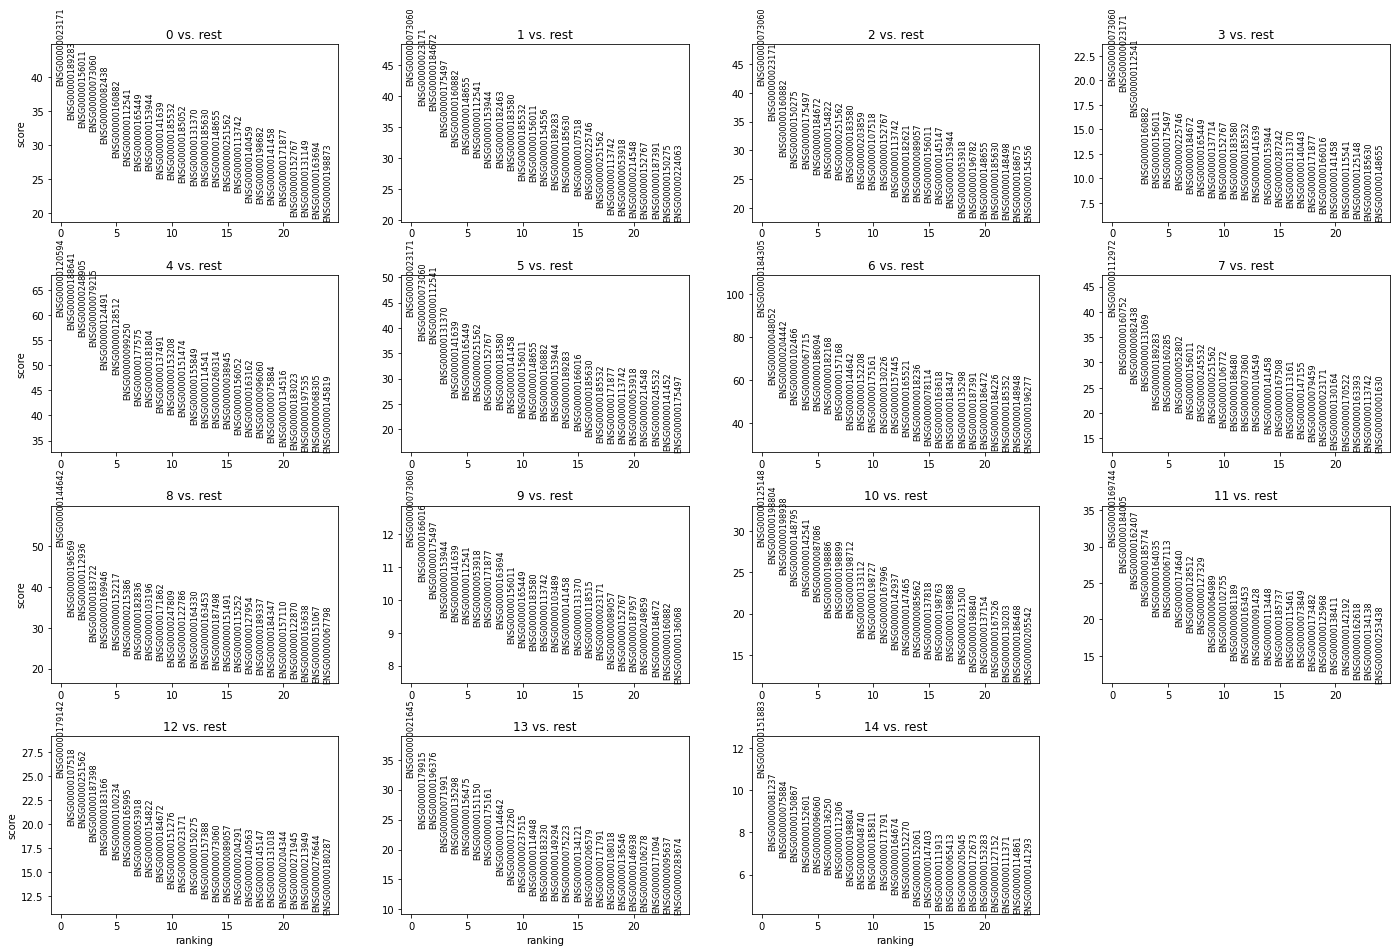

top gene names
                 0                1                2                3  \
0  ENSG00000023171  ENSG00000073060  ENSG00000073060  ENSG00000073060   
1  ENSG00000189283  ENSG00000023171  ENSG00000023171  ENSG00000023171   
2  ENSG00000156011  ENSG00000184672  ENSG00000160882  ENSG00000112541   
3  ENSG00000073060  ENSG00000175497  ENSG00000150275  ENSG00000160882   
4  ENSG00000082438  ENSG00000160882  ENSG00000175497  ENSG00000156011   

                 4                5                6                7  \
0  ENSG00000120594  ENSG00000023171  ENSG00000184305  ENSG00000112972   
1  ENSG00000188641  ENSG00000073060  ENSG00000048052  ENSG00000160752   
2  ENSG00000248905  ENSG00000112541  ENSG00000204442  ENSG00000082438   
3  ENSG00000079215  ENSG00000131370  ENSG00000102466  ENSG00000131069   
4  ENSG00000124491  ENSG00000141639  ENSG00000067715  ENSG00000189283   

                 8                9               10               11  \
0  ENSG00000144642  ENSG0000007306

In [18]:
algorithm_scanpy_filtered = {}
algorithm_top_gene_ids = {}
algorithm_top_gene_names = {}
for algorithm in algorithm_filtered:
    #print(display.HTML('<h1>{algorithm} first phase QC</h1><a class="anchor-link" href="#{algorithm}-first-phase-QC">¶</a>'.format(algorithm=algorithm)))
    print("{algorithm} clustering".format(algorithm=algorithm))
    algorithm_scanpy_filtered[algorithm] = algorithm_filtered[algorithm][algorithm_filtered[algorithm].obs.n_genes_by_counts < 2000, :]
    algorithm_scanpy_filtered[algorithm] = algorithm_scanpy_filtered[algorithm][algorithm_scanpy_filtered[algorithm].obs.pct_counts_mt < 2.5, :]
    
    scanpy.pp.normalize_total(algorithm_scanpy_filtered[algorithm], target_sum=30000)
    scanpy.pp.log1p(algorithm_scanpy_filtered[algorithm])
    scanpy.pp.highly_variable_genes(algorithm_scanpy_filtered[algorithm], min_mean=0.0125, max_mean=3, min_disp=0.5)
    scanpy.pl.highly_variable_genes(algorithm_scanpy_filtered[algorithm])
    algorithm_scanpy_filtered[algorithm].raw = algorithm_scanpy_filtered[algorithm]
    algorithm_scanpy_filtered[algorithm] = algorithm_scanpy_filtered[algorithm][:, algorithm_scanpy_filtered[algorithm].var.highly_variable]
   
    scanpy.pp.regress_out( algorithm_scanpy_filtered[algorithm], ['total_counts', 'pct_counts_mt'])
    scanpy.pp.scale( algorithm_scanpy_filtered[algorithm], max_value=10)
    scanpy.tl.pca(algorithm_scanpy_filtered[algorithm], svd_solver='arpack')
    scanpy.pl.pca(algorithm_scanpy_filtered[algorithm])

    scanpy.pl.pca_variance_ratio(algorithm_scanpy_filtered[algorithm], log=True)
    
    scanpy.pp.neighbors(algorithm_scanpy_filtered[algorithm], n_neighbors=10, n_pcs=40)
    scanpy.tl.umap(algorithm_scanpy_filtered[algorithm])
    scanpy.pl.umap(algorithm_scanpy_filtered[algorithm])
    
    scanpy.tl.louvain(algorithm_scanpy_filtered[algorithm])
    scanpy.pl.umap(algorithm_scanpy_filtered[algorithm], color=['louvain'])
    
    scanpy.tl.rank_genes_groups(algorithm_scanpy_filtered[algorithm], 'louvain', method='t-test')
    scanpy.pl.rank_genes_groups(algorithm_scanpy_filtered[algorithm], n_genes=25, sharey=False, gene_symbols='gene_name')
    
    algorithm_top_gene_ids[algorithm] = pandas.DataFrame(algorithm_scanpy_filtered[algorithm].uns['rank_genes_groups']['names'])    
    if algorithm == "tenx solo uniq":
        algorithm_top_gene_names[algorithm] = algorithm_top_gene_ids[algorithm].applymap(lambda x: v32m_gene_id_to_name.get(x, x))
    else:
        algorithm_top_gene_names[algorithm] = algorithm_top_gene_ids[algorithm].applymap(lambda x: v29_gene_id_to_name.get(x, x))
    print('top gene names')
    print(algorithm_top_gene_names[algorithm].head(5))

# Gene IDs in common after scanpy filtering

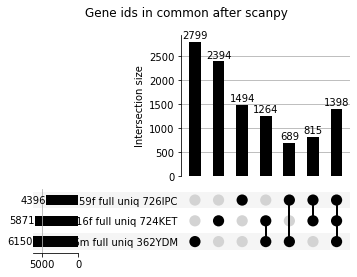

In [19]:
common_filtered_gene_base_contents = {}
for algorithm in algorithm_scanpy_filtered:
    #if algorithm == 'tenx solo uniq':
    #    common_filtered_gene_base_contents[algorithm] = {gene_id for gene_id in algorithm_scanpy_filtered[algorithm].var_names}
    #else:
    #common_filtered_gene_base_contents[algorithm] = {gene_id.split('.')[0] for gene_id in algorithm_scanpy_filtered[algorithm].var_names}
    common_filtered_gene_base_contents[algorithm] = set(algorithm_scanpy_filtered[algorithm].var_names)

# tenx is using gencode.v32.primary_assembly.annotation.gtf.filtered
common_filtered_gene_base_set = upsetplot.from_contents(common_filtered_gene_base_contents)

f = pyplot.figure()
f.suptitle("Gene ids in common after scanpy")
_ = upsetplot.plot(common_filtered_gene_base_set, show_counts=True, fig=f)

In [20]:
def build_confusion_matrix(left, right, N=20):
    confusion = {}
    for cluster in left:
        for gene in left[cluster].head(N):
            confusion.setdefault(gene, {})['left'] = int(cluster)

    for cluster in right:
        for gene in right[cluster].head(N):
            confusion.setdefault(gene, {})['right'] = int(cluster)

    last_left = int(left.columns[-1]) + 1
    last_right = int(right.columns[-1]) + 1

    confusion_matrix = numpy.zeros((last_left+1, last_right+1))

    for gene in confusion:
        x = confusion[gene].get('left', last_left)
        y = confusion[gene].get('right', last_right)
        confusion_matrix[x,y] += 1
    return confusion_matrix

# Confusion matrices between top N genes in each cluster

In [21]:
def plot_algorithm_confusion(table, programs=None, N=20):
    if programs is None:
        programs = list(table.keys())
    confusion = {}
    plot_size = len(programs)-1
    figsize = (3 * plot_size, 3 * plot_size)
    f = pyplot.figure(figsize=figsize)

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            cm = build_confusion_matrix(table[name_x], table[name_y], N)
            seaborn.heatmap(cm, annot=False, ax=ax)
            
            if x == 0:
                ax.set_ylabel(name_y)
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    f.suptitle("Gene name confusion matrix of top {} genes".format(N))
    #f.tight_layout()


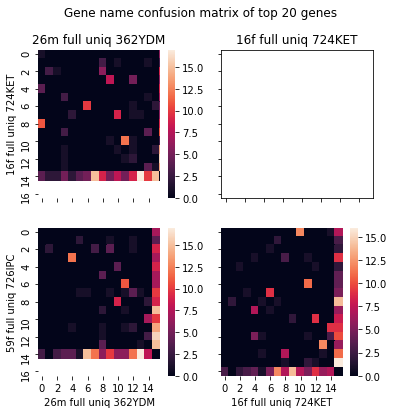

In [22]:
plot_algorithm_confusion(algorithm_top_gene_names, N=20)

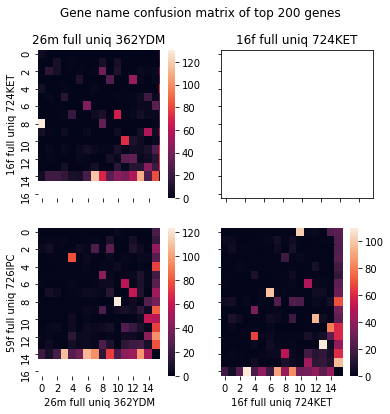

In [23]:
plot_algorithm_confusion(algorithm_top_gene_names, N=200)

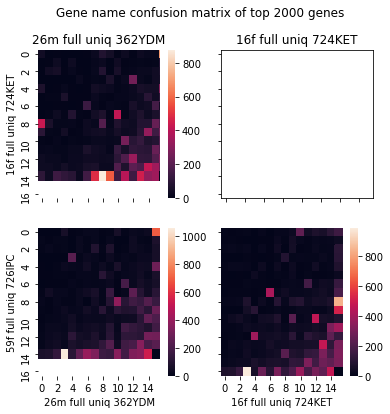

In [24]:
plot_algorithm_confusion(algorithm_top_gene_names, N=2000)

In [25]:
algorithm_filtered

{'26m full uniq 362YDM': AnnData object with n_obs × n_vars = 11964 × 27701
     obs: 'counts', 'ngenes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
     var: 'gene_name', 'gene_type', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts',
 '16f full uniq 724KET': AnnData object with n_obs × n_vars = 15812 × 29057
     obs: 'counts', 'ngenes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
     var: 'gene_name', 'gene_type', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts',
 '59f full uniq 726IPC': AnnData object with n_obs × n_vars = 12732 × 27200
     obs: 'counts', 'ngenes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
     var: 'gene_name', 'gene_type', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'}

In [26]:
for k in algorithm_filtered:
    print(algorithm_filtered[k].var_names)

Index(['ENSG00000238009', 'ENSG00000241860', 'ENSG00000241599',
       'ENSG00000286448', 'ENSG00000235146', 'ENSG00000229905',
       'ENSG00000237491', 'ENSG00000177757', 'ENSG00000228794',
       'ENSG00000225880',
       ...
       'ENSG00000276256', 'ENSG00000273496', 'ENSG00000278384',
       'ENSG00000273748', 'ENSG00000271254', 'ENSG00000276345',
       'ENSG00000277761', 'ENSG00000276017', 'ENSG00000278817',
       'ENSG00000277196'],
      dtype='object', length=27701)
Index(['ENSG00000238009', 'ENSG00000239906', 'ENSG00000241860',
       'ENSG00000241599', 'ENSG00000286448', 'ENSG00000235146',
       'ENSG00000229905', 'ENSG00000237491', 'ENSG00000177757',
       'ENSG00000228794',
       ...
       'ENSG00000278704', 'ENSG00000276256', 'ENSG00000278384',
       'ENSG00000273748', 'ENSG00000271254', 'ENSG00000276345',
       'ENSG00000273554', 'ENSG00000278633', 'ENSG00000276017',
       'ENSG00000278817'],
      dtype='object', length=29057)
Index(['ENSG00000238009', 'ENSG0

# Lets smoosh the datasets together

In [27]:
combined = anndata.concat(
    [algorithm_filtered[x] for x in algorithm_filtered],
    merge='same',
)
combined

AnnData object with n_obs × n_vars = 40508 × 26210
    obs: 'counts', 'ngenes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'gene_type', 'mt'

In [28]:
combined.obs['donor'] = [x.split('_')[1] for x in combined.obs_names]

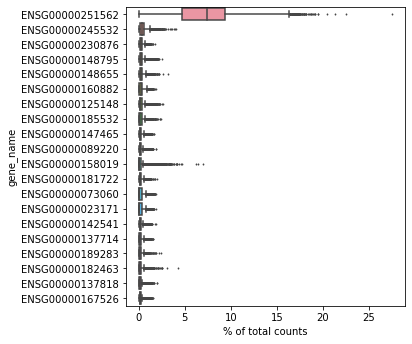

... storing 'donor' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWa

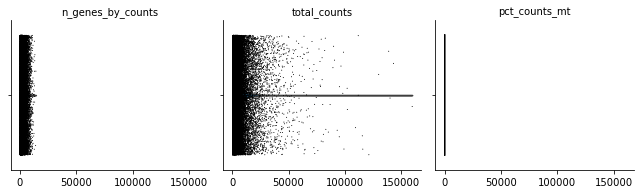

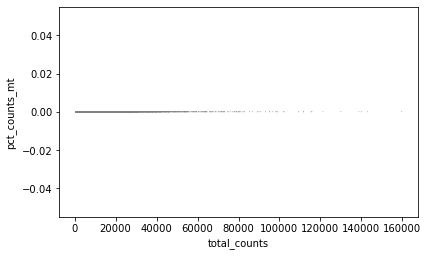

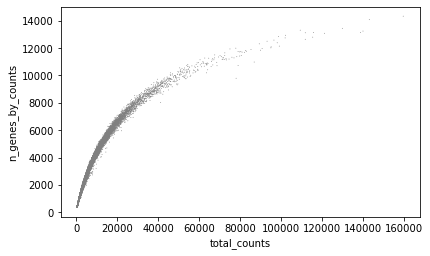

In [29]:
scanpy.pl.highest_expr_genes(combined, n_top=20, gene_symbols='gene_name')
scanpy.pp.filter_cells(combined, min_genes=200)
scanpy.pp.filter_genes(combined, min_cells=3)
algorithm_filtered[algorithm].var['mt'] = combined.var['gene_name'].str.startswith("MT-")
scanpy.pp.calculate_qc_metrics(combined, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
scanpy.pl.violin(
    combined,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, multi_panel=True)
scanpy.pl.scatter(combined, x='total_counts', y='pct_counts_mt')
scanpy.pl.scatter(combined, x='total_counts', y='n_genes_by_counts')        

/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


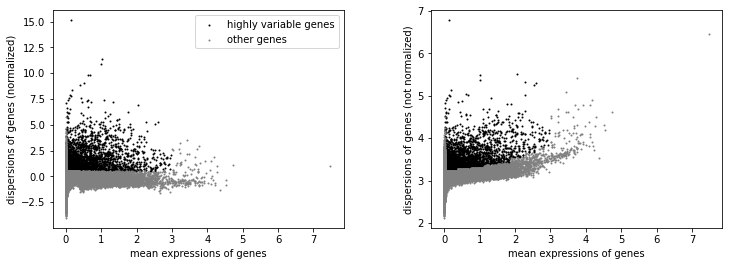

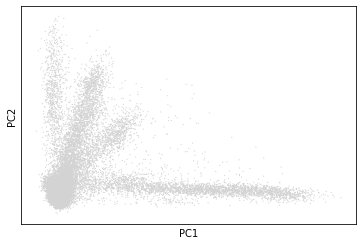

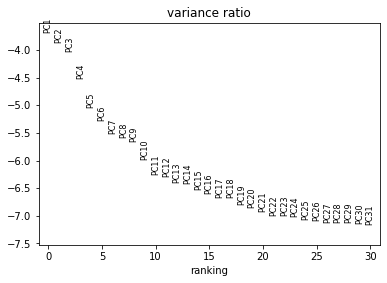

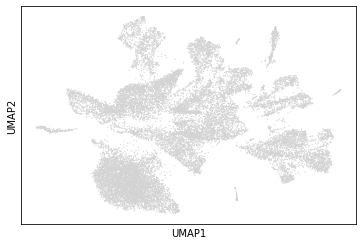

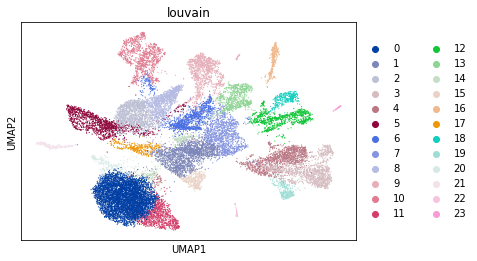

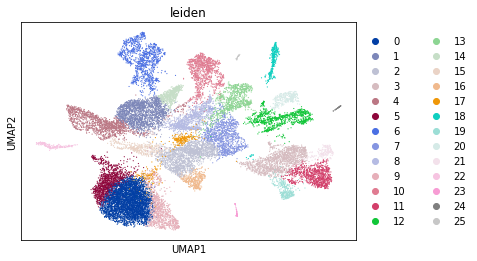

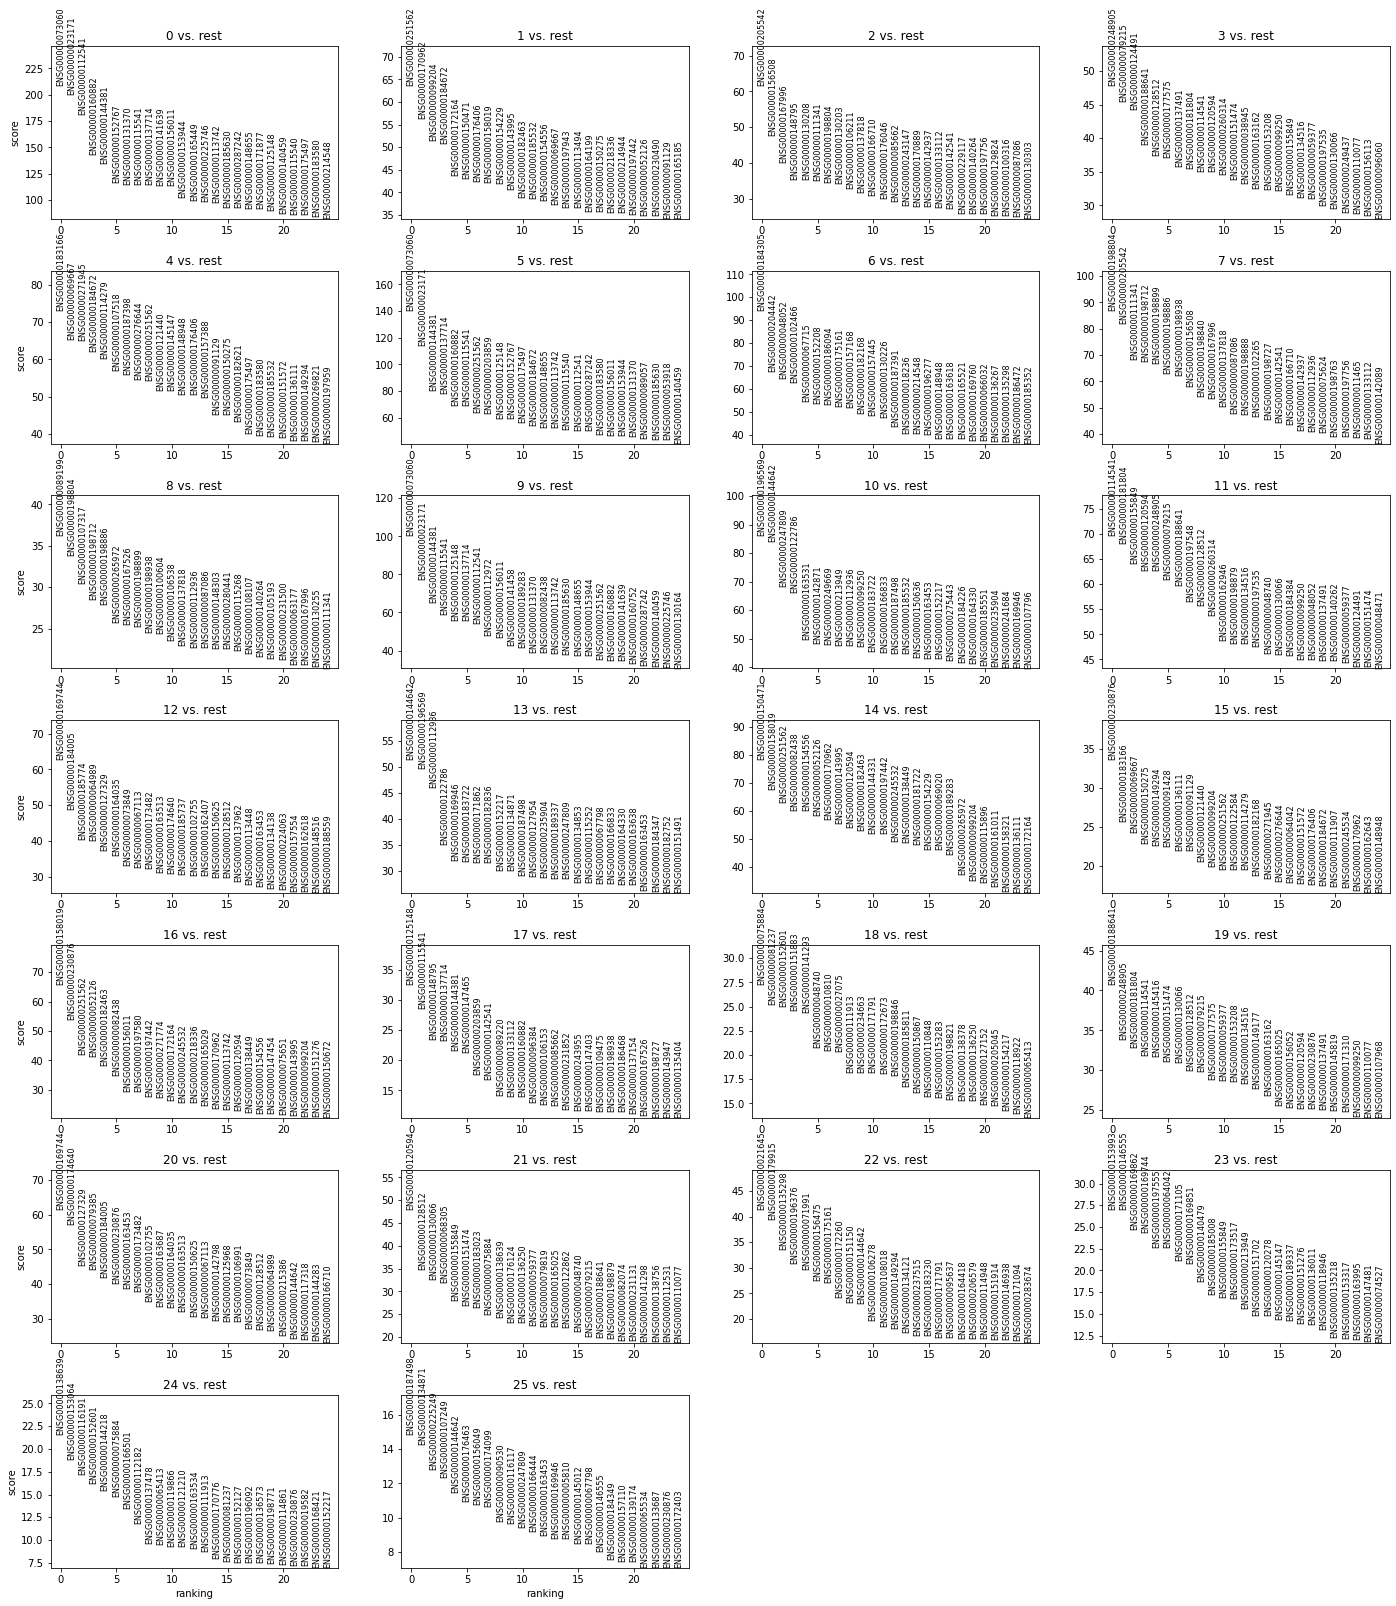

top gene names
top gene names


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,ENSG00000073060,ENSG00000251562,ENSG00000205542,ENSG00000248905,ENSG00000183166,ENSG00000073060,ENSG00000184305,ENSG00000198804,ENSG00000089199,ENSG00000073060,...,ENSG00000158019,ENSG00000125148,ENSG00000075884,ENSG00000188641,ENSG00000169744,ENSG00000120594,ENSG00000021645,ENSG00000153993,ENSG00000138639,ENSG00000187498
1,ENSG00000023171,ENSG00000170962,ENSG00000156508,ENSG00000079215,ENSG00000069667,ENSG00000023171,ENSG00000204442,ENSG00000205542,ENSG00000198804,ENSG00000023171,...,ENSG00000230876,ENSG00000115541,ENSG00000081237,ENSG00000248905,ENSG00000174640,ENSG00000128512,ENSG00000179915,ENSG00000146555,ENSG00000153064,ENSG00000134871
2,ENSG00000112541,ENSG00000099204,ENSG00000167996,ENSG00000124491,ENSG00000271945,ENSG00000144381,ENSG00000048052,ENSG00000111341,ENSG00000107317,ENSG00000144381,...,ENSG00000251562,ENSG00000148795,ENSG00000152601,ENSG00000181804,ENSG00000127329,ENSG00000130066,ENSG00000135298,ENSG00000169862,ENSG00000116191,ENSG00000225249
3,ENSG00000160882,ENSG00000184672,ENSG00000148795,ENSG00000188641,ENSG00000184672,ENSG00000137714,ENSG00000102466,ENSG00000198712,ENSG00000198712,ENSG00000115541,...,ENSG00000052126,ENSG00000137714,ENSG00000151883,ENSG00000114541,ENSG00000079385,ENSG00000068305,ENSG00000196376,ENSG00000169744,ENSG00000152601,ENSG00000107249
4,ENSG00000144381,ENSG00000172164,ENSG00000130208,ENSG00000128512,ENSG00000114279,ENSG00000160882,ENSG00000067715,ENSG00000198899,ENSG00000198886,ENSG00000125148,...,ENSG00000182463,ENSG00000144381,ENSG00000141293,ENSG00000145416,ENSG00000184005,ENSG00000155849,ENSG00000071991,ENSG00000197555,ENSG00000144218,ENSG00000144642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26205,ENSG00000155849,ENSG00000114541,ENSG00000112972,ENSG00000143995,ENSG00000134871,ENSG00000198121,ENSG00000169554,ENSG00000175497,ENSG00000171877,ENSG00000247809,...,ENSG00000198121,ENSG00000173320,ENSG00000170390,ENSG00000248197,ENSG00000170500,ENSG00000185052,ENSG00000111344,ENSG00000270641,ENSG00000069702,ENSG00000114650
26206,ENSG00000138449,ENSG00000155849,ENSG00000048052,ENSG00000134138,ENSG00000198502,ENSG00000145819,ENSG00000245532,ENSG00000269821,ENSG00000103489,ENSG00000276644,...,ENSG00000155849,ENSG00000234428,ENSG00000133121,ENSG00000214548,ENSG00000287242,ENSG00000095397,ENSG00000145864,ENSG00000169891,ENSG00000120594,ENSG00000287242
26207,ENSG00000099250,ENSG00000099250,ENSG00000075391,ENSG00000069667,ENSG00000129824,ENSG00000138449,ENSG00000148655,ENSG00000287242,ENSG00000112541,ENSG00000106211,...,ENSG00000075884,ENSG00000241316,ENSG00000169302,ENSG00000184828,ENSG00000185352,ENSG00000112541,ENSG00000115252,ENSG00000058668,ENSG00000185565,ENSG00000107518
26208,ENSG00000128512,ENSG00000129824,ENSG00000270641,ENSG00000187391,ENSG00000162551,ENSG00000169946,ENSG00000183878,ENSG00000270641,ENSG00000141639,ENSG00000149294,...,ENSG00000270641,ENSG00000129824,ENSG00000137462,ENSG00000170500,ENSG00000270641,ENSG00000141639,ENSG00000155307,ENSG00000287242,ENSG00000133121,ENSG00000118515


In [30]:
#print(display.HTML('<h1>{algorithm} first phase QC</h1><a class="anchor-link" href="#{algorithm}-first-phase-QC">¶</a>'.format(algorithm=algorithm)))
combined_scanpy = combined[combined.obs.n_genes_by_counts < 2000, :]
combined_scanpy = combined_scanpy[combined_scanpy.obs.pct_counts_mt < 2.5, :]

scanpy.pp.normalize_total(combined_scanpy, target_sum=30000)
scanpy.pp.log1p(combined_scanpy)
scanpy.pp.highly_variable_genes(combined_scanpy, min_mean=0.0125, max_mean=3, min_disp=0.5)
scanpy.pl.highly_variable_genes(combined_scanpy)
combined_scanpy.raw = combined_scanpy
combined_scanpy = combined_scanpy[:, combined_scanpy.var.highly_variable]

scanpy.pp.regress_out(combined_scanpy, ['total_counts', 'pct_counts_mt'])
scanpy.pp.scale(combined_scanpy, max_value=10)
scanpy.tl.pca(combined_scanpy, svd_solver='arpack')
scanpy.pl.pca(combined_scanpy)

scanpy.pl.pca_variance_ratio(combined_scanpy, log=True)

scanpy.pp.neighbors(combined_scanpy, n_neighbors=10, n_pcs=40)
scanpy.tl.umap(combined_scanpy)
scanpy.pl.umap(combined_scanpy)

scanpy.tl.louvain(combined_scanpy)
scanpy.pl.umap(combined_scanpy, color=['louvain'])

scanpy.tl.leiden(combined_scanpy)
scanpy.pl.umap(combined_scanpy, color=['leiden'])

scanpy.tl.rank_genes_groups(combined_scanpy, 'leiden', method='t-test')
scanpy.pl.rank_genes_groups(combined_scanpy, n_genes=25, sharey=False, gene_symbols='gene_name')

combined_top_gene_ids = pandas.DataFrame(combined_scanpy.uns['rank_genes_groups']['names'])    
print('top gene names')
combined_top_gene_names = combined_top_gene_ids.applymap(lambda x: v29_gene_id_to_name.get(x, x))
print('top gene names')
combined_top_gene_names

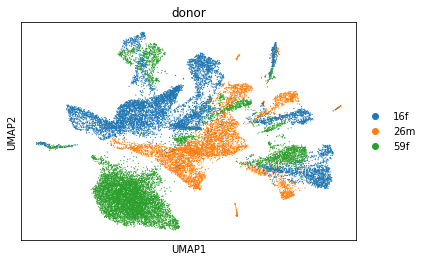

In [31]:
scanpy.pl.umap(combined_scanpy, color=['donor'])

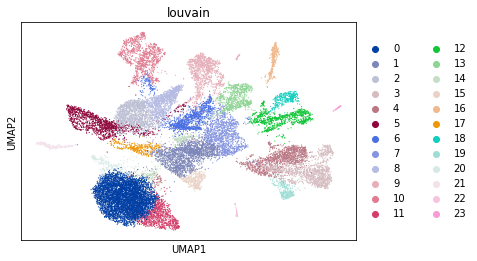

In [32]:
scanpy.pl.umap(combined_scanpy, color=['louvain'])

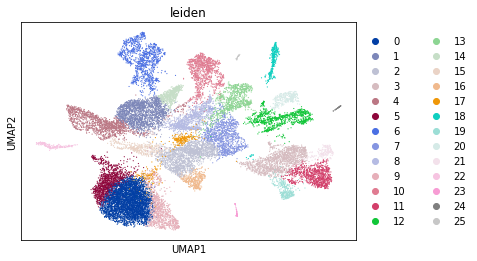

In [33]:
scanpy.pl.umap(combined_scanpy, color=['leiden'])